In [69]:
import os, json, jsonlines
from transformers import LlamaTokenizer
from transformers import LlamaForCausalLM
import random
import argparse
import torch
device = 'cuda:6'
tokenizer = LlamaTokenizer.from_pretrained("/data/maxb/tag/model_cache/llama-ckpt/llama-2-7b-chat-hf")
model = LlamaForCausalLM.from_pretrained("/data/maxb/tag/model_cache/llama-ckpt/llama-2-7b-chat-hf").to(device)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at /data/maxb/tag/model_cache/llama-ckpt/llama-2-7b-chat-hf and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.22.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.27.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'mo

In [93]:
model = None

In [26]:

prompt = 'Singled Out debuted on'
batch = tokenizer(prompt, return_tensors='pt', padding=True)
outputs = model.generate(
    input_ids = batch['input_ids'].to(device),
    attention_mask = batch['attention_mask'].to(device),
    max_new_tokens = 30,
    output_scores = True,
    return_dict_in_generate = True
)


In [27]:
# outputs.sequences.detach().cpu().numpy().tolist()
text = tokenizer.decode(outputs.sequences.detach().cpu().numpy().tolist()[0], skip_special_tokens=True)
text

'Singled Out debuted on MTV in 1995 and was hosted by John Norris. The show featured a panel of comedians and musicians who would watch'

In [5]:
# len(outputs.scores)
# outputs.scores[0].size()
len(outputs.sequences[0])
outputs.sequences.size(1)
# batch['input_ids']
# input_token_len = batch['input_ids'].size(1)
# input_token_len

37

In [35]:
import torch
import torch.nn.functional as F
input_token_len = batch['input_ids'].size(1)
output_token_len = outputs.sequences.size(1)
new_token_len = output_token_len - input_token_len

next_token_score = pred1 = F.softmax(outputs.scores[0], dim=1)
print(next_token_score.shape)
top1_token = torch.argmax(next_token_score, dim=-1)
top1_text = tokenizer.decode(top1_token.detach().cpu().numpy().tolist()[0], skip_special_tokens=True)
top1_ppl = next_token_score[0,top1_token.detach().cpu().numpy().tolist()[0]].detach().cpu().numpy()
print(top1_token, top1_text, top1_ppl)

# top1_token
# top1_ppl

# target_new_ppl
# target_new_token1_rank
# target_new_ppl
# target_true_pl
# target_true_token1_rank
# target_true_ppl

torch.Size([1, 32000])
tensor([28982], device='cuda:7') MTV 0.439788


In [52]:
def perplexity(
    model ,
    tok,
    text: str,
    max_input_length: int = None,
):
    inputs = tok(
        [text], return_tensors="pt", max_length=max_input_length, truncation=True
    ).to("cuda")

    logits = torch.nn.functional.log_softmax(model(**inputs.to(device)).logits, dim=2)
    print(logits.shape)
    log_probs = torch.gather(logits[:, :-1, :], 2, inputs["input_ids"][:, 1:, None])[0]
    target_p = torch.exp(log_probs[-1])
    print(target_p)
    
    a = logits[0, -2, :].detach().cpu().numpy().tolist()
    sorted_id = sorted(range(len(a)), key=lambda k: a[k], reverse=True)
    a_order = sorted_id.index(28982)
    print(a_order)
    # first_token = tok.encode("MTV")[1]
    # target_p_ = torch.exp(logits[:, -2, first_token])
    # print(target_p_)
    # Perplexity = exp(-1/N * log P(x_1, ..., x_n))
    return target_p

perplexity(model, tokenizer, 'Singled Out debuted on MTV')

torch.Size([1, 8, 32000])
tensor([0.4398], device='cuda:7', grad_fn=<ExpBackward0>)
0


tensor([0.4398], device='cuda:7', grad_fn=<ExpBackward0>)

In [67]:
def perplexity(
    model,
    tok,
    text: str,
    max_input_length: int = None,
):
    """
    Computes perplexity of a piece of text, measured on a reference model.
    Text is truncated to max_input_length tokens.
    """

    inputs = tok(
        [text], return_tensors="pt", max_length=max_input_length, truncation=True
    ).to("cuda")

    logits = torch.nn.functional.log_softmax(model(**inputs.to(device)).logits, dim=2)
    log_probs = torch.gather(logits[:, :-1, :], 2, inputs["input_ids"][:, 1:, None])[0]
    print(log_probs.shape)
    target_p = torch.exp(log_probs[-1]) * torch.exp(log_probs[-2])
    print(target_p)
    # Perplexity = exp(-1/N * log P(x_1, ..., x_n))
    # return torch.exp(1 / 2 * (log_probs[-1]+log_probs[-2])).item()
perplexity(model, tokenizer, 'Singled Out debuted on MTV')

torch.Size([7, 1])
tensor([0.1679], device='cuda:7', grad_fn=<MulBackward0>)


In [75]:
tokenizer('Gibraltar is located in Europe')

{'input_ids': [1, 15347, 1705, 12637, 338, 5982, 297, 4092], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [89]:
import json
import re, string
def normalize(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# with open('/data/maxb/mememe/EasyEdit/see_logits.json', 'r') as f:
#     genertation = json.load(f)
# with open('/data/maxb/mememe/EasyEdit/cf/counterfact.json', 'r') as f:
#     data = json.load(f)
# cnt = 0
# for i, (g, d) in enumerate(zip(genertation, data)):
#     assert g['case_id'] == d['case_id']
#     flag = 0
#     # print(g)
#     # print(d)
#     if normalize(d['requested_rewrite']['target_true']['str']) in normalize(g['generation']):
#         cnt += 1
#         flag = 1
#     if i%1000 == 0:
#         print(d['requested_rewrite']['target_true']['str'], g['generation'], flag)


In [5]:
cnt/len(genertation)

0.3428988548747662

In [99]:
from tqdm import tqdm
with open('/data/maxb/mememe/EasyEdit/cf/counterfact.json', 'r') as f:
    data = json.load(f)

relations = []
for i, d in enumerate(data):
    relations.append(d['requested_rewrite']['relation_id'])
    
relations = set(relations)
len(relations)

# demo = []
# demo_id = []
# for ri in relations:
#     for i, d in enumerate(data):
#         if d['requested_rewrite']['relation_id'] == ri:
#             demo.append(d['requested_rewrite']['prompt'].format(d['requested_rewrite']['subject'])+ " " +d['requested_rewrite']['target_true']['str'])
#             demo_id.append(i)
#             break
# len(demo)
# demos = '\n'.join(demo)


def find_demos(data, relation, id):
    demo = []
    for d in data:
        if d['case_id'] != id and d['requested_rewrite']['relation_id'] == relation:
            demo.append(d['requested_rewrite']['prompt'].format(d['requested_rewrite']['subject'])+ " " +d['requested_rewrite']['target_true']['str'])
            if len(demo) == 10:
                break
    assert len(demo) == 10 or d == data[-1]
    return '\n'.join(demo)
data = data[500:]
for i, d in enumerate(tqdm(data)):
    demos = find_demos(data[:500], d['requested_rewrite']['relation_id'], d['case_id'])
    prompt = "Complete the sentence with an entity.\n" + demos + '\n' + d['requested_rewrite']['prompt'].format(d['requested_rewrite']['subject'])
    # print(prompt)
    q =  d['requested_rewrite']['prompt'].format(d['requested_rewrite']['subject'])
    if q in demos:
        data[i]['output'] = '<demo>'
    batch = tokenizer(prompt, return_tensors='pt', padding=True)
    outputs = model.generate(
        input_ids = batch['input_ids'].to(device),
        attention_mask = batch['attention_mask'].to(device),
        max_new_tokens = 12,
        do_sample=False
    )
    text = tokenizer.decode(outputs.detach().cpu().numpy().tolist()[0], skip_special_tokens=True)
    text = text.replace(prompt, '')
    text = text.split('\n')[0]
    # print(text)
    data[i]['output'] = text
    if i%100 == 0:
        # print(prompt)
        print(d['requested_rewrite']['prompt'].format(d['requested_rewrite']['subject']), text)
        # print(text)
    

  0%|          | 1/21419 [00:00<3:26:46,  1.73it/s]

Nick Raphael originates from  New York


  0%|          | 101/21419 [00:59<3:32:26,  1.67it/s]

Yazid I follows the religion of  Islam


  1%|          | 201/21419 [01:58<3:23:59,  1.73it/s]

How I Met Your Mother premieres on  CBS


  1%|▏         | 301/21419 [02:58<3:14:51,  1.81it/s]

Boeing Helicopters is owned by  Boeing


  2%|▏         | 401/21419 [03:57<3:17:23,  1.77it/s]

Michael Umaña professionally plays the sport  baseball


  2%|▏         | 501/21419 [04:55<3:03:51,  1.90it/s]

Purple Hearts's music label is  _____________.


  3%|▎         | 601/21419 [05:55<3:25:18,  1.69it/s]

Calder Freeway, in  California


  3%|▎         | 701/21419 [06:53<3:18:35,  1.74it/s]

Mainichi Shinbun, that was created in  Japan


  4%|▎         | 801/21419 [07:51<3:16:49,  1.75it/s]

1985 Southeast Asian Games is located in  Singapore


  4%|▍         | 901/21419 [08:49<3:21:25,  1.70it/s]

Max Wilson was native to  New York


  5%|▍         | 1001/21419 [09:47<3:18:28,  1.71it/s]

Chris Daughtry plays the instrument  guitar


  5%|▌         | 1101/21419 [10:46<3:15:29,  1.73it/s]

home counties is within  England


  6%|▌         | 1201/21419 [11:45<3:18:13,  1.70it/s]

Mac OS X Panther was created by  Apple


  6%|▌         | 1301/21419 [12:44<3:18:10,  1.69it/s]

Wesley Lopes Beltrame, who plays the position  of forward


  7%|▋         | 1401/21419 [13:43<3:14:26,  1.72it/s]

Franz Reuleaux's expertise is  engineering


  7%|▋         | 1501/21419 [14:41<3:17:43,  1.68it/s]

Jithan Ramesh, who has a citizenship from  India


  7%|▋         | 1601/21419 [15:40<3:17:46,  1.67it/s]

Marcos Moshinsky's area of work is  economics


  8%|▊         | 1701/21419 [16:38<3:16:00,  1.68it/s]

Ellar Coltrane works as  actor


  8%|▊         | 1801/21419 [17:36<2:58:26,  1.83it/s]

Gayngs was created in  Minneapolis


  9%|▉         | 1901/21419 [18:34<3:11:58,  1.69it/s]

Opeth, from  Sweden


  9%|▉         | 2001/21419 [19:33<3:07:51,  1.72it/s]

Ty Detmer plays as  quarterback


 10%|▉         | 2101/21419 [20:30<3:11:03,  1.69it/s]

The profession of Milt Kogan is  a lawyer


 10%|█         | 2201/21419 [21:28<2:53:51,  1.84it/s]

Andorran Football Federation belongs to the organization of  UEFA


 11%|█         | 2301/21419 [22:26<3:11:08,  1.67it/s]

United Grain Growers is headquartered in  Winnipeg


 11%|█         | 2401/21419 [23:25<3:06:09,  1.70it/s]

Honey War is in  California


 12%|█▏        | 2501/21419 [24:23<3:03:35,  1.72it/s]

The headquarters of New Kabul Bank is in  Kabul


 12%|█▏        | 2601/21419 [25:22<3:00:50,  1.73it/s]

Biff Wellington is native to  New York


 13%|█▎        | 2701/21419 [26:21<3:08:06,  1.66it/s]

2011 Yemeni revolution is located in  Yemen


 13%|█▎        | 2801/21419 [27:20<3:03:28,  1.69it/s]

Magnus Lindgren performs  jazz


 14%|█▎        | 2901/21419 [28:18<3:01:56,  1.70it/s]

Roland Topor, a native  French


 14%|█▍        | 3001/21419 [29:17<3:00:21,  1.70it/s]

The original language of Yalkut Yosef is  Hebrew


 14%|█▍        | 3101/21419 [30:18<3:01:28,  1.68it/s]

The official language of Tavannes is  French


 15%|█▍        | 3201/21419 [31:16<3:00:36,  1.68it/s]

Gaspard Gourgaud was employed in  Turin


 15%|█▌        | 3301/21419 [32:15<2:59:11,  1.69it/s]

The language of Sostiene Pereira was  Portuguese


 16%|█▌        | 3401/21419 [33:14<3:02:55,  1.64it/s]

In Huittinen, they understand  and speak the language Swedish


 16%|█▋        | 3501/21419 [34:12<2:50:38,  1.75it/s]

Gordon Scott's occupation is  actor


 17%|█▋        | 3601/21419 [35:11<2:53:05,  1.72it/s]

Jiang Qinqin spoke the language  Chinese


 17%|█▋        | 3701/21419 [36:09<2:50:07,  1.74it/s]

Stonegard was started in  Copenhagen


 18%|█▊        | 3801/21419 [37:08<2:57:08,  1.66it/s]

The profession of Peter Abelard is  philosopher


 18%|█▊        | 3901/21419 [38:06<2:49:02,  1.73it/s]

Jack Cassidy died in the city of  New York


 19%|█▊        | 4001/21419 [39:04<2:54:30,  1.66it/s]

Gabriel Zubeir Wako, a citizen of  Kenya


 19%|█▉        | 4101/21419 [40:02<2:53:00,  1.67it/s]

Keystone Corridor can be found in  Pennsylvania


 20%|█▉        | 4201/21419 [41:01<2:47:21,  1.71it/s]

George Walden took up work in  London


 20%|██        | 4301/21419 [41:59<2:56:49,  1.61it/s]

Which position does Nolan Schaefer play? They play as  quarterback


 21%|██        | 4401/21419 [42:57<2:40:14,  1.77it/s]

Sidhi district, in  India


 21%|██        | 4501/21419 [43:55<2:47:56,  1.68it/s]

Joachim Barrande was employed in  Warsaw


 21%|██▏       | 4601/21419 [44:54<2:44:27,  1.70it/s]

We Are All Legends performs  jazz


 22%|██▏       | 4701/21419 [45:52<2:46:29,  1.67it/s]

Zuber Usman speaks  the language Urdu


 22%|██▏       | 4801/21419 [46:50<2:44:24,  1.68it/s]

Sony SLT camera is developed by  Sony


 23%|██▎       | 4901/21419 [47:48<2:40:34,  1.71it/s]

Henry Pickering Bowditch passed away at  Boston


 23%|██▎       | 5001/21419 [48:46<2:48:12,  1.63it/s]

Benin belongs to the continent of  Africa


 24%|██▍       | 5101/21419 [49:45<2:37:30,  1.73it/s]

Giovanni Bassano was employed in  Venice


 24%|██▍       | 5201/21419 [50:43<2:40:59,  1.68it/s]

The language of The Reckoning of Time is  Spanish


 25%|██▍       | 5301/21419 [51:41<2:31:05,  1.78it/s]

Anders Ågnes Konradsen, who plays the position  of forward


 25%|██▌       | 5401/21419 [52:40<2:36:48,  1.70it/s]

Tim Ingold's expertise is  anthropology


 26%|██▌       | 5501/21419 [53:38<2:30:32,  1.76it/s]

Suleiman I of Persia is a  sultan


 26%|██▌       | 5601/21419 [54:36<2:33:40,  1.72it/s]

Valmiki speaks the language  Sanskrit


 27%|██▋       | 5701/21419 [55:34<2:40:44,  1.63it/s]

Liv Ullmann writes in  Norwegian


 27%|██▋       | 5801/21419 [56:33<2:33:38,  1.69it/s]

Alston G. Dayton works as  politician


 28%|██▊       | 5901/21419 [57:31<2:31:23,  1.71it/s]

Ferrari 612 Scaglietti is a product of  Ferrari


 28%|██▊       | 6001/21419 [58:29<2:31:49,  1.69it/s]

Lyon is a twin city of  Moscow


 28%|██▊       | 6101/21419 [59:27<2:18:34,  1.84it/s]

Toumani Diagouraga, who plays the position  of midfielder


 29%|██▉       | 6201/21419 [1:00:25<2:25:55,  1.74it/s]

Jean Hyppolite speaks  French


 29%|██▉       | 6301/21419 [1:01:23<2:25:39,  1.73it/s]

What does Bobby Watson play? They play  jazz


 30%|██▉       | 6401/21419 [1:02:21<2:14:22,  1.86it/s]

Hungary is a part of the  UEFA


 30%|███       | 6501/21419 [1:03:19<2:23:24,  1.73it/s]

Gmina Stara Kornica, in  Poland


 31%|███       | 6601/21419 [1:04:17<2:24:10,  1.71it/s]

The native language of Aletta Jacobs is  Dutch


 31%|███▏      | 6701/21419 [1:05:16<2:30:04,  1.63it/s]

Johnny Baldwin, who plays the position  of cornerback


 32%|███▏      | 6801/21419 [1:06:14<2:24:46,  1.68it/s]

Ernie Davis is a professional  football player


 32%|███▏      | 6901/21419 [1:07:13<2:17:58,  1.75it/s]

Bare Essence debuted on  Showtime


 33%|███▎      | 7001/21419 [1:08:11<2:17:49,  1.74it/s]

Alexey Miller, a native  speaker of Russian


 33%|███▎      | 7101/21419 [1:09:10<2:17:25,  1.74it/s]

Nokia X is created by  Nokia


 34%|███▎      | 7201/21419 [1:10:08<2:14:50,  1.76it/s]

Eva Cantarella speaks  Italian


 34%|███▍      | 7301/21419 [1:11:06<2:15:37,  1.73it/s]

Fergus McMaster was born in  Toronto


 35%|███▍      | 7401/21419 [1:12:04<2:12:06,  1.77it/s]

CNN Presents was released on  CNN


 35%|███▌      | 7501/21419 [1:13:02<2:16:31,  1.70it/s]

Noon Meem Danish works as  artist


 35%|███▌      | 7601/21419 [1:14:00<2:13:32,  1.72it/s]

Tagus river is located in  the continent of Europe


 36%|███▌      | 7701/21419 [1:14:59<2:19:31,  1.64it/s]

The original language of I Love Another was  Spanish


 36%|███▋      | 7801/21419 [1:15:57<2:18:04,  1.64it/s]

Rhine is located in  the continent of Europe


 37%|███▋      | 7901/21419 [1:16:56<2:08:13,  1.76it/s]

Henri Estienne originated from  Paris


 37%|███▋      | 8001/21419 [1:17:53<2:05:02,  1.79it/s]

The Steepwater Band, created in  Chicago


 38%|███▊      | 8101/21419 [1:18:52<2:15:14,  1.64it/s]

Sean Burke plays as  goaltender


 38%|███▊      | 8201/21419 [1:19:50<2:09:01,  1.71it/s]

Matt Riddle, playing the  instrument guitar


 39%|███▉      | 8301/21419 [1:20:49<2:03:29,  1.77it/s]

Fredrik Stang worked in  Oslo


 39%|███▉      | 8401/21419 [1:21:47<2:04:48,  1.74it/s]

Shoranur, in  the state of Tamil Nadu, India


 40%|███▉      | 8501/21419 [1:22:45<2:10:19,  1.65it/s]

Kiko Alonso plays as  linebacker


 40%|████      | 8601/21419 [1:23:43<2:04:46,  1.71it/s]

Suzuki APV is developed by  Suzuki


 41%|████      | 8701/21419 [1:24:41<2:04:42,  1.70it/s]

Leroy Jones, playing the  instrument guitar


 41%|████      | 8801/21419 [1:25:40<2:00:25,  1.75it/s]

The twin city of Tirana is  Pristina


 42%|████▏     | 8901/21419 [1:26:37<1:58:59,  1.75it/s]

Montour County can be found in  Pennsylvania


 42%|████▏     | 9001/21419 [1:27:36<1:57:26,  1.76it/s]

Trailer Park Boys was from  Canada


 42%|████▏     | 9101/21419 [1:28:34<1:55:04,  1.78it/s]

Agatha Christie's Marple debuted on  PBS


 43%|████▎     | 9201/21419 [1:29:33<1:57:11,  1.74it/s]

The language of LiveJournal is  English


 43%|████▎     | 9301/21419 [1:30:31<1:57:31,  1.72it/s]

Nick Cave writes in  English


 44%|████▍     | 9401/21419 [1:31:30<2:00:36,  1.66it/s]

Where is Barn Elms? It is located in  London


 44%|████▍     | 9501/21419 [1:32:29<1:53:54,  1.74it/s]

The twin city of Cincinnati is  Moscow


 45%|████▍     | 9601/21419 [1:33:27<1:55:31,  1.70it/s]

Jane Tranter, who works for  BBC


 45%|████▌     | 9701/21419 [1:34:25<1:53:12,  1.73it/s]

The language of Enthiran is  Tamil


 46%|████▌     | 9801/21419 [1:35:23<1:53:01,  1.71it/s]

Pedro Calungsod expired at  Manila


 46%|████▌     | 9901/21419 [1:36:21<1:49:24,  1.75it/s]

The genre played by Peak Records is  jazz


 47%|████▋     | 10001/21419 [1:37:19<1:52:06,  1.70it/s]

The language of NOW Lebanon is  Arabic


 47%|████▋     | 10101/21419 [1:38:17<1:47:47,  1.75it/s]

Michel Portal speaks  French


 48%|████▊     | 10201/21419 [1:39:15<1:50:35,  1.69it/s]

Cartographers Range is located in  the continent of Antarctica


 48%|████▊     | 10301/21419 [1:40:13<1:48:53,  1.70it/s]

Cape Selborne is a part of the continent of  Antarctica


 49%|████▊     | 10401/21419 [1:41:12<1:46:40,  1.72it/s]

What does Paul Gonsalves play? They play  jazz


 49%|████▉     | 10501/21419 [1:42:11<1:46:03,  1.72it/s]

The occupation of Gargi Roychowdhury is  a scientist


 49%|████▉     | 10601/21419 [1:43:10<1:46:16,  1.70it/s]

Case Western Reserve University is based in  Cleveland


 50%|████▉     | 10701/21419 [1:44:08<1:46:34,  1.68it/s]

Tariq Saleh works as  writer


 50%|█████     | 10801/21419 [1:45:07<1:45:53,  1.67it/s]

Teatro Comunale Florence, located in  Italy


 51%|█████     | 10901/21419 [1:46:05<1:43:01,  1.70it/s]

Norman Rockwell, a native  English speaker


 51%|█████▏    | 11001/21419 [1:47:03<1:39:28,  1.75it/s]

Ikegami Tsushinki was formed in  Tokyo


 52%|█████▏    | 11101/21419 [1:48:02<1:43:24,  1.66it/s]

Andreas Peter Bernstorff used to work in  Copenhagen


 52%|█████▏    | 11201/21419 [1:49:01<1:38:27,  1.73it/s]

Bentley Continental Flying Spur is a product of  Bentley


 53%|█████▎    | 11301/21419 [1:49:58<1:35:55,  1.76it/s]

Tashkent is in  Asia


 53%|█████▎    | 11401/21419 [1:50:57<1:37:53,  1.71it/s]

Bundesautobahn 40 is owned by  Germany


 54%|█████▎    | 11501/21419 [1:51:55<1:37:59,  1.69it/s]

The mother tongue of Henri Diamant-Berger is  French


 54%|█████▍    | 11601/21419 [1:52:53<1:35:46,  1.71it/s]

Hobart Zoo is located in the country of  Australia


 55%|█████▍    | 11701/21419 [1:53:52<1:30:14,  1.79it/s]

James Jackson Putnam originates from  New York


 55%|█████▌    | 11801/21419 [1:54:49<1:32:15,  1.74it/s]

Munich, which is located in  Germany


 56%|█████▌    | 11901/21419 [1:55:48<1:32:27,  1.72it/s]

William Herschel's expertise is  astronomy


 56%|█████▌    | 12001/21419 [1:56:47<1:28:54,  1.77it/s]

Ali-Akbar Shahnazi was originally from  Tehran


 56%|█████▋    | 12101/21419 [1:57:45<1:27:12,  1.78it/s]

The mother tongue of Jacobus Henricus van 't Hoff is  Dutch


 57%|█████▋    | 12201/21419 [1:58:43<1:31:10,  1.69it/s]

Eugene Wigner works in the area of  nuclear physics


 57%|█████▋    | 12301/21419 [1:59:41<1:30:10,  1.69it/s]

Randy Moss plays  football


 58%|█████▊    | 12401/21419 [2:00:39<1:25:33,  1.76it/s]

Jules de Polignac writes in  French


 58%|█████▊    | 12501/21419 [2:01:36<1:26:15,  1.72it/s]

Marsh Glacier belongs to the continent of  Antarctica


 59%|█████▉    | 12601/21419 [2:02:34<1:28:27,  1.66it/s]

Kyle Boller plays as  quarterback


 59%|█████▉    | 12701/21419 [2:03:33<1:24:57,  1.71it/s]

Dennis Taylor, who is employed by  IBM


 60%|█████▉    | 12801/21419 [2:04:32<1:25:17,  1.68it/s]

Roy Hargrove, the  trumpet


 60%|██████    | 12901/21419 [2:05:30<1:22:51,  1.71it/s]

The twin city of Athens is  Thessaloniki


 61%|██████    | 13001/21419 [2:06:28<1:20:57,  1.73it/s]

Anil Kapoor speaks the language  Hindi


 61%|██████    | 13101/21419 [2:07:26<1:21:38,  1.70it/s]

BBC Four is owned by  BBC


 62%|██████▏   | 13201/21419 [2:08:24<1:17:44,  1.76it/s]

Charlotte/Douglas International Airport is owned by  Charlotte


 62%|██████▏   | 13301/21419 [2:09:23<1:17:04,  1.76it/s]

Joachim Meisner has the position of  archbishop


 63%|██████▎   | 13401/21419 [2:10:21<1:23:06,  1.61it/s]

Emmanuelle Seigner holds a citizenship from  France


 63%|██████▎   | 13501/21419 [2:11:20<1:16:12,  1.73it/s]

Heinrich Heine took up work in  Berlin


 63%|██████▎   | 13601/21419 [2:12:18<1:16:59,  1.69it/s]

Jacques Dupin, speaker of  French


 64%|██████▍   | 13701/21419 [2:13:16<1:14:46,  1.72it/s]

Mehmed VI was born in  Istanbul


 64%|██████▍   | 13801/21419 [2:14:14<1:15:48,  1.67it/s]

In Jokkmokk Municipality, they understand  the language Sami


 65%|██████▍   | 13901/21419 [2:15:13<1:11:18,  1.76it/s]

What does Norris Turney play? They play  jazz


 65%|██████▌   | 14001/21419 [2:16:11<1:13:17,  1.69it/s]

The original language of The Voice Israel was  Hebrew


 66%|██████▌   | 14101/21419 [2:17:09<1:12:37,  1.68it/s]

Alice Isaaz is a native speaker of  French


 66%|██████▋   | 14201/21419 [2:18:07<1:09:40,  1.73it/s]

Where is Chicago Rockets? It is located in  Chicago


 67%|██████▋   | 14301/21419 [2:19:05<1:07:28,  1.76it/s]

The headquarters of Da Capo Press is in  New York


 67%|██████▋   | 14401/21419 [2:20:04<1:09:19,  1.69it/s]

Collins Harbour is in  the continent of Antarctica


 68%|██████▊   | 14501/21419 [2:21:02<1:08:02,  1.69it/s]

In Canton of Valais, an official language is  French


 68%|██████▊   | 14601/21419 [2:22:01<1:05:35,  1.73it/s]

In Bosnia and Herzegovina, the language spoken is  Bosnian


 69%|██████▊   | 14701/21419 [2:23:00<1:08:12,  1.64it/s]

Bayerischer Rundfunk's headquarters are in  Munich


 69%|██████▉   | 14801/21419 [2:23:59<1:02:20,  1.77it/s]

Torreys Peak is in  Colorado


 70%|██████▉   | 14901/21419 [2:24:57<1:03:15,  1.72it/s]

Christoph Willibald von Gluck found employment in  Vienna


 70%|███████   | 15001/21419 [2:25:55<1:01:28,  1.74it/s]

The mother tongue of Paolo Tiralongo is  Italian


 71%|███████   | 15101/21419 [2:26:54<1:01:37,  1.71it/s]

The language of International Political Sociology is  English


 71%|███████   | 15201/21419 [2:27:52<1:02:34,  1.66it/s]

The language of Espreso TV is  Spanish


 71%|███████▏  | 15301/21419 [2:28:50<58:10,  1.75it/s]  

route 75, located in  the country of United States


 72%|███████▏  | 15401/21419 [2:29:49<58:47,  1.71it/s]  

Excuse 17 started in  New York City


 72%|███████▏  | 15501/21419 [2:30:47<55:00,  1.79it/s]  

Bath Stone, that originated in  England


 73%|███████▎  | 15601/21419 [2:31:45<57:13,  1.69it/s]  

Packard, whose headquarters are in  Detroit


 73%|███████▎  | 15701/21419 [2:32:43<54:46,  1.74it/s]

Concentration debuted on  NBC


 74%|███████▍  | 15801/21419 [2:33:42<55:19,  1.69it/s]

The language of Arahan is  Korean


 74%|███████▍  | 15901/21419 [2:34:40<54:11,  1.70it/s]

Time for Revenge, that was from  Russia


 75%|███████▍  | 16001/21419 [2:35:39<51:30,  1.75it/s]

Al-Dhahabi is affiliated with the religion  Islam


 75%|███████▌  | 16101/21419 [2:36:37<53:22,  1.66it/s]

Porsche 997, developed by  Porsche


 76%|███████▌  | 16201/21419 [2:37:35<50:11,  1.73it/s]

Sir James Whitehead, 1st Baronet took up work in  London


 76%|███████▌  | 16301/21419 [2:38:33<48:01,  1.78it/s]

Urban I holds the title of  bishop


 77%|███████▋  | 16401/21419 [2:39:31<46:02,  1.82it/s]

Pete Atkin, of  BBC


 77%|███████▋  | 16501/21419 [2:40:30<48:14,  1.70it/s]

In Republic of Adygea, the language spoken is  Circassian


 78%|███████▊  | 16601/21419 [2:41:27<46:43,  1.72it/s]

OneDrive, a product manufactured by  Microsoft


 78%|███████▊  | 16701/21419 [2:42:26<45:50,  1.72it/s]

Pitchfork's headquarters are in  Chicago


 78%|███████▊  | 16801/21419 [2:43:24<43:56,  1.75it/s]

Sense8 premieres on  Netflix


 79%|███████▉  | 16901/21419 [2:44:22<42:21,  1.78it/s]

Basilio Pompilj holds the position of  cardinal


 79%|███████▉  | 17001/21419 [2:45:21<44:28,  1.66it/s]

The language of Glas Slavonije is  Croatian


 80%|███████▉  | 17101/21419 [2:46:19<42:27,  1.69it/s]

Guiding Light premieres on  CBS


 80%|████████  | 17201/21419 [2:47:17<42:38,  1.65it/s]

Where is NatFilm Festival? It is located in  Norway


 81%|████████  | 17301/21419 [2:48:16<41:11,  1.67it/s]

In Porvoo, they understand  Finnish


 81%|████████  | 17401/21419 [2:49:14<38:40,  1.73it/s]

The Caterpillar Wish from  Brazil


 82%|████████▏ | 17501/21419 [2:50:13<38:33,  1.69it/s]

Toyota Camry is a product of  Toyota


 82%|████████▏ | 17601/21419 [2:51:11<36:47,  1.73it/s]

Grianan of Aileach, in  Ireland


 83%|████████▎ | 17701/21419 [2:52:09<35:33,  1.74it/s]

Microsoft Office is created by  Microsoft


 83%|████████▎ | 17801/21419 [2:53:08<35:44,  1.69it/s]

The twin city of Istanbul is  Izmir


 84%|████████▎ | 17901/21419 [2:54:06<34:51,  1.68it/s]

ice cream cone is located in  United States


 84%|████████▍ | 18001/21419 [2:55:04<32:44,  1.74it/s]

FHM India, that was from  India


 85%|████████▍ | 18101/21419 [2:56:03<31:56,  1.73it/s]

Frans G. Bengtsson spoke the language  Swedish


 85%|████████▍ | 18201/21419 [2:57:01<31:30,  1.70it/s]

Bob Wallace, who works for  BBC


 85%|████████▌ | 18301/21419 [2:58:00<30:26,  1.71it/s]

The location of 2015 World Men's Handball Championship is  Qatar


 86%|████████▌ | 18401/21419 [2:58:58<29:13,  1.72it/s]

tatami, that was formulated in  Japan


 86%|████████▋ | 18501/21419 [2:59:57<28:43,  1.69it/s]

Berlin State Opera can be found in  Germany


 87%|████████▋ | 18601/21419 [3:00:55<27:45,  1.69it/s]

Carl Theodor Zahle used to work in  Copenhagen


 87%|████████▋ | 18701/21419 [3:01:54<26:17,  1.72it/s]

Antanas Baranauskas has the position of  bishop


 88%|████████▊ | 18801/21419 [3:02:52<25:26,  1.71it/s]

Snobs, that was from  United Kingdom


 88%|████████▊ | 18901/21419 [3:03:50<24:19,  1.73it/s]

B. Hick and Sons, whose headquarters are in  Sydney


 89%|████████▊ | 19001/21419 [3:04:48<24:23,  1.65it/s]

Uqba ibn Nafi is affiliated with the religion  Islam


 89%|████████▉ | 19101/21419 [3:05:47<22:01,  1.75it/s]

Don Durant works as  actor


 90%|████████▉ | 19201/21419 [3:06:45<21:12,  1.74it/s]

Roman Reigns is a professional  wrestler


 90%|█████████ | 19301/21419 [3:07:44<21:09,  1.67it/s]

The original language of Nationalencyklopedin was  Swedish


 91%|█████████ | 19401/21419 [3:08:43<19:55,  1.69it/s]

Panch phoron, that was formulated in  Bangladesh


 91%|█████████ | 19501/21419 [3:09:41<18:42,  1.71it/s]

Grace Lynn Kung is originally from  Hong Kong


 92%|█████████▏| 19601/21419 [3:10:40<17:43,  1.71it/s]

The original language of Kampf um Rom I is  German


 92%|█████████▏| 19701/21419 [3:11:38<16:21,  1.75it/s]

Everard Home passed away at  Cambridge


 92%|█████████▏| 19801/21419 [3:12:36<15:55,  1.69it/s]

Poya is follower of  Buddhism


 93%|█████████▎| 19901/21419 [3:13:34<14:55,  1.70it/s]

The genre played by Harold Dejan is  jazz


 93%|█████████▎| 20001/21419 [3:14:32<14:07,  1.67it/s]

Marcel Pagnol, a native  French


 94%|█████████▍| 20101/21419 [3:15:30<12:22,  1.77it/s]

Wild Bill Davis plays the  instrument piano


 94%|█████████▍| 20201/21419 [3:16:29<11:46,  1.72it/s]

Astaldi is based in  Rome


 95%|█████████▍| 20301/21419 [3:17:27<10:53,  1.71it/s]

3-2-1 Contact debuted on  PBS


 95%|█████████▌| 20401/21419 [3:18:26<09:34,  1.77it/s]

Gripin started in  Tokyo


 96%|█████████▌| 20501/21419 [3:19:24<08:49,  1.73it/s]

What does Ottawan play? They play  jazz


 96%|█████████▌| 20601/21419 [3:20:22<08:04,  1.69it/s]

Sima Qian specializes in  history


 97%|█████████▋| 20701/21419 [3:21:19<06:54,  1.73it/s]

Joseph Clay was native to  New York


 97%|█████████▋| 20801/21419 [3:22:18<05:55,  1.74it/s]

Al Ahmadi Governorate is located in  the country of Oman


 98%|█████████▊| 20901/21419 [3:23:16<05:01,  1.72it/s]

Akbar follows the religion of  Islam


 98%|█████████▊| 21001/21419 [3:24:14<04:09,  1.68it/s]

The profession of Eoin Ryan, Jnr is  politician


 99%|█████████▊| 21101/21419 [3:25:14<03:10,  1.67it/s]

Johann Georg Gmelin specializes in  chemistry


 99%|█████████▉| 21201/21419 [3:26:12<02:06,  1.73it/s]

Wiener Zeitung, by  Wiener Zeitung


 99%|█████████▉| 21301/21419 [3:27:10<01:07,  1.75it/s]

Matt Dennis is known for performing  jazz


100%|█████████▉| 21401/21419 [3:28:08<00:10,  1.72it/s]

Constantine the Great is affiliated with the religion  Christianity


100%|██████████| 21419/21419 [3:28:18<00:00,  1.71it/s]


In [50]:
data[0]['output']

' French'

In [98]:
cnt =0
for i, d in enumerate(data):
    flag = 0
    # print(d)
    # if i in demo_id:
    #     d['output'] = ['<demo>', -1]
    #     continue
    if normalize(d['output']) and normalize(d['requested_rewrite']['target_true']['str']) in normalize(d['output']):
        cnt += 1
        flag = 1
    d['output'] = [d['output'], flag]
    # if i%10 == 0:
    print(d['requested_rewrite']['target_true']['str'], d['output'], flag)
cnt/(1000)

Sunshine [' Fantasy', 0] 0
Brunswick [' Braunschweig', 0] 0
Montreal [' Montreal', 1] 1
Japan [' the United States', 0] 0
Beijing [' Rome', 0] 0
Sydney [' Manchester', 0] 0
linebacker [' midfielder', 0] 0
Liverpool [' London', 0] 0
Chicago [' Los Angeles', 0] 0
Sydney [' Sydney', 1] 1
goaltender [' goaltender', 1] 1
opera [' opera', 1] 1
Athens [' Athens', 1] 1
Antarctica [' the continent of Antarctica', 1] 1
Apple [' Apple', 1] 1
Warsaw [' Berlin', 0] 0
NBC [' NBC', 1] 1
Vancouver [' Los Angeles', 0] 0
Germany [' Federal Republic of Germany', 1] 1
Korean [' Russian', 0] 0
CBS [' MTV', 0] 0
mathematics [' mathematics', 1] 1
BBC [' BBC', 1] 1
French [' French', 1] 1
Dublin [' New York', 0] 0
Dutch [' Dutch', 1] 1
Toronto [' Toronto', 1] 1
Oregon [' Oregon', 1] 1
Canada [' Canada', 1] 1
jazz [' jazz', 1] 1
India [' India', 1] 1
Athens [' Tokyo', 0] 0
jazz [' jazz', 1] 1
Antarctica [' Antarctica', 1] 1
English [' German', 0] 0
French [' the language French', 1] 1
Swansea [' Cambria', 0] 0

0.634

In [2]:
import json
with open('counterfact_with_icl.json', 'r') as f:
    # json.dump(data, f, indent=2)
    data = json.load(f)

In [59]:
relations

{'P101',
 'P103',
 'P106',
 'P108',
 'P127',
 'P1303',
 'P131',
 'P136',
 'P138',
 'P140',
 'P1412',
 'P159',
 'P17',
 'P176',
 'P178',
 'P19',
 'P190',
 'P20',
 'P264',
 'P27',
 'P276',
 'P30',
 'P36',
 'P364',
 'P37',
 'P39',
 'P407',
 'P413',
 'P449',
 'P463',
 'P495',
 'P641',
 'P740',
 'P937'}

21885 21885


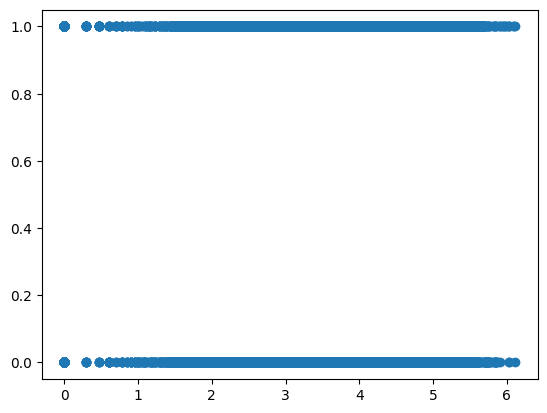

pearson系数： 0.11283570886447235
   P-Value： 6.160557630839482e-63


In [18]:
# correlation
from matplotlib import pyplot
import math
from scipy.stats import pearsonr,spearmanr
icl_recall = [ d['output'][1] for d in data ]
with open('/data/maxb/mememe/EasyEdit/cf/wiki_freq_caseid_output_total.json', 'r') as f:
    freq = json.load(f)
freq = [ f['freq'] for f in freq ]

icl_recall_ = []
freq_ = []
for i in range(len(icl_recall)):
    if icl_recall[i] != -1:
        icl_recall_.append(icl_recall[i])
        freq_.append(freq[i])
print(len(icl_recall_), len(freq_))
# print(icl_recall_[:10], freq_[:10])
pyplot.scatter(freq_, icl_recall_)
pyplot.show()

r = spearmanr(freq_, icl_recall_)
print("pearson系数：",r[0])
print("   P-Value：",r[1])

In [20]:
import numpy as np
def freq_acc(freq, icl_recall):
    print(max(freq), min(freq), (max(freq)-min(freq))/10)
    x_left = np.arange(0, max(freq), (max(freq)-min(freq))/10)
    x_mid = [ xi + (max(freq)-min(freq))/20 for xi in x_left ]
    x_left = np.append(x_left, max(freq)+0.001)
    # print(x_left)
    y = []
    for i in range(len(x_mid)):
        y.append([])
    for i in range(len(icl_recall)):
        if icl_recall[i] != -1 and freq[i] > 0:
            # for j in range(len(x_left)):
            j = 0
            while freq[i] >= x_left[j]:
                j += 1
            # print(j-1, freq[i])
            y[j-1].append(icl_recall[i])
            # print(y)
    y_acc = []
    for yi in y:
        
        if len(yi)==0:
            y_acc.append(0)
        else:
            # print('{:.2f}'.format(sum(yi)/len(yi)))
            y_acc.append(sum(yi)/len(yi))
    # print(x_mid, y_acc)
    # pyplot.bar(x_mid, y_acc, (max(freq)-min(freq))/20)
    # pyplot.show()
    return [x_mid, y_acc, (max(freq)-min(freq))/20]
# print(y[0])

0.16218805602445366


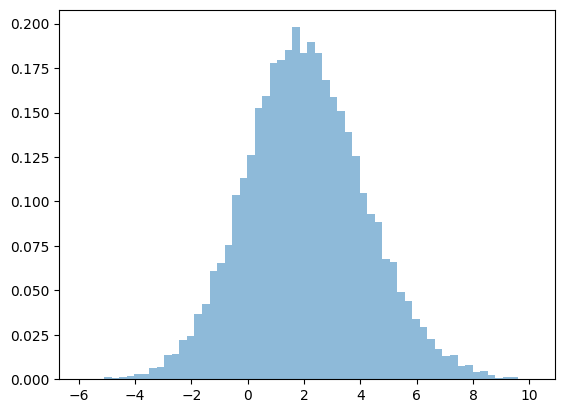

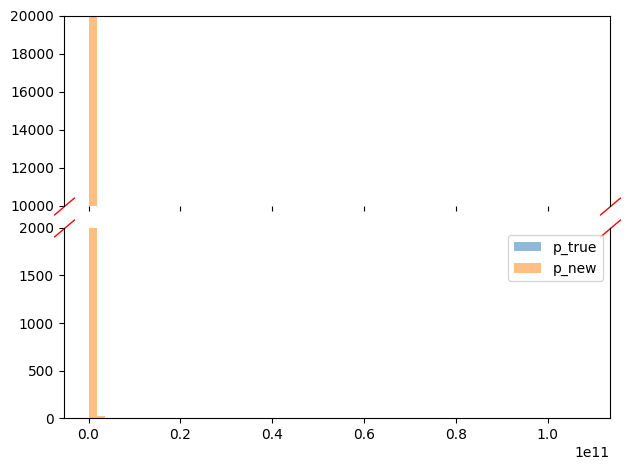

In [92]:
from scipy.stats import pearsonr,spearmanr
with open('/data/maxb/mememe/EasyEdit/see_ppl_completion.json', 'r') as f:
    plain = json.load(f)
# plain_recall = [ 1 if d['target_p_generation'] == d['target_p_true'] else 0 for d in plain ]
# plain_recall = [ d['target_p_true'] for d in plain]

# freq_ = []
# plain_recall_ = []
# for i in range(len(freq)):
#     if freq[i] > 0:
#         freq_.append(freq[i])
#         plain_recall_.append(plain_recall[i])

# pyplot.scatter(freq_, plain_recall_)
# pyplot.show()

# r = spearmanr(freq_, plain_recall_)
# print("pearson系数：",r[0])
# print("   P-Value：",r[1])
p_true = [ d['p_true'] for d in plain]
p_new = [ d['p_new'] for d in plain]
p_diff = [math.log(d['p_new']/ d['p_true'], 10) for d in plain]
cnt = 0
for pi in range(len(p_diff)):
    if p_new[pi] <= p_true[pi]:
        cnt+=1
print(cnt/len(p_diff))
# print(p_diff)
pyplot.hist(x = p_diff,
            bins = 60,
            alpha=0.5,
            density=True)
pyplot.savefig('ppl_div_v2.pdf',  bbox_inches="tight", pad_inches=0.0)
pyplot.show()
fig, (ax1, ax2) = pyplot.subplots(2, 1, sharex=True)
                          
ax1.hist(x = p_true, # 指定绘图数据
         bins = 60, # 指定直方图中条块的个数
         label='p_true',
         alpha = 0.5,
        #  density=True
         )
ax1.hist(x = p_new, # 指定绘图数据
         bins = 60, # 指定直方图中条块的个数
         label='p_new',
         alpha = 0.5,
        #  density=True
         )
ax2.hist(x = p_true, # 指定绘图数据
         bins = 60, # 指定直方图中条块的个数
         label='p_true',
         alpha = 0.5,
        #  density=True
         )
ax2.hist(x = p_new, # 指定绘图数据
         bins = 60, # 指定直方图中条块的个数
         label='p_new',
         alpha = 0.5,
        #  density=True
         )
pyplot.legend(loc='upper right')
ax1.set_ylim(10000, 20000)  # 子图1设置y轴范围，只显示部分图
ax2.set_ylim(0, 2000)
ax1.spines['bottom'].set_visible(False)#关闭子图1中底部脊
ax2.spines['top'].set_visible(False)
d = .85
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15,
              linestyle='none', color='r', mec='r', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0],transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
fig.tight_layout(h_pad=0.1)


(array([3.11373899e+14, 0.00000000e+00, 2.84152126e+10, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.42076063e+10]),
 array([0.00000000e+00, 3.21113341e-15, 6.42226683e-15, 9.63340024e-15,
        1.28445337e-14, 1.60556671e-14, 1.92668005e-14, 2.24779339e-14,
        2.56890673e-14, 2.89002007e-14, 3.21113341e-14]),
 <BarContainer object of 10 artists>)

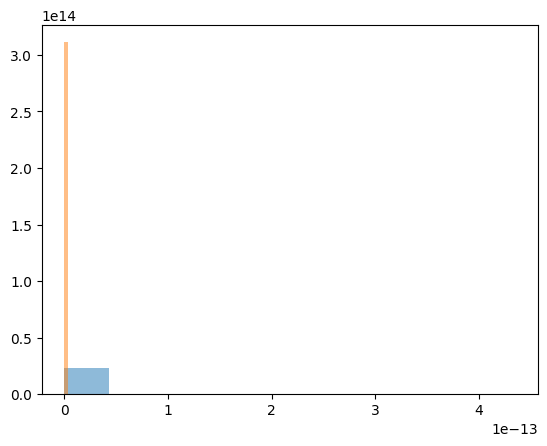

In [40]:
with open('/data/maxb/mememe/EasyEdit/see_ppl.json', 'r') as f:
    plain = json.load(f)
p_true = [ d['p_true'] for d in plain]
p_new = [ d['p_new'] for d in plain]
pyplot.hist(x = p_true, # 指定绘图数据
         bins = 10, # 指定直方图中条块的个数
         label='p_true',
         alpha = 0.5,
         density=True
         )
pyplot.hist(x = p_new, # 指定绘图数据
         bins = 10, # 指定直方图中条块的个数
         label='p_new',
         alpha = 0.5,
         density=True
         )

In [22]:
from scipy.stats import spearmanr
relations = []
for i, d in enumerate(data):
    relations.append(d['requested_rewrite']['relation_id'])
    
relations = set(relations)
print(len(list(relations)))
with open('/data/maxb/mememe/EasyEdit/cf/wiki_freq_caseid_output_total.json', 'r') as f:
    freq_data = json.load(f)
with open('/data/maxb/mememe/EasyEdit/see_logits_v2.json', 'r') as f:
    plain = json.load(f)
data_bins = []
for ri in relations:
    data_ri = []
    for i, d in enumerate(data):
        if d['requested_rewrite']['relation_id'] == ri:
            data_ri.append(d)
    data_bins.append({'relation': ri, 'data': data_ri})
figures = []
labels = []
for bin in data_bins:
    print(bin['relation'], len(bin['data']))
    rel_path = '/data/maxb/mememe/EasyEdit/cf/graphs_json/' + bin['relation'] + '.jsonl'
    with open(rel_path, 'r') as f:
        for line in f:
            rel = eval(line)['pattern']
            break
    label = bin['relation'] + '--' + rel
    labels.append(label)
    recall = []
    plain_recall = []
    freq = []
    for di in bin['data'][1:]:
        case_id = di['case_id']
        recall.append(di['output'][1])
        for j in range(len(freq_data)):
            if freq_data[j]['case_id'] == case_id:
                freq.append(freq_data[j]['freq'])
        
        for j in range(len(plain)):
            if plain[j]['case_id'] == case_id:
                plain_recall.append(1 if plain[j]['target_p_generation'] == plain[j]['target_p_true'] else 0)
        
    figures.append(freq_acc(freq, recall))
    # freq_acc(freq, plain_recall)
    # pyplot.scatter(freq, recall)
    # pyplot.show()
    # print(plain_recall)
    r = spearmanr(freq, recall)
    print("spearman系数：",r[0])
    print("   P-Value：",r[1])
    labels[-1] += ':' + '{:.2f}'.format(r[0])
    # r = spearmanr(freq, plain_recall)
    # print("spearman系数：",r[0])
    # print("   P-Value：",r[1])


34
P108 350
5.8102889860521625 1.0791812460476247 0.47311077400045376
spearman系数： 0.21973928331608059
   P-Value： 3.4569775098466496e-05
P176 911
5.09915212365681 0.0 0.509915212365681
spearman系数： 0.11024443841995762
   P-Value： 0.0008645869971562271
P740 774
5.973484383108707 0.0 0.5973484383108707
spearman系数： 0.2986730419033707
   P-Value： 2.1580698290445066e-17
P159 756
5.5312425454378165 0.0 0.5531242545437817
spearman系数： 0.21461123783261402
   P-Value： 2.5738234450267668e-09
P20 816
5.169768452456512 0.0 0.5169768452456511
spearman系数： 0.22068816118200893
   P-Value： 1.8992815268653148e-10
P27 958
5.954630788104943 0.0 0.5954630788104943
spearman系数： 0.16565328537010676
   P-Value： 2.556684231944366e-07
P1303 513
5.827077060027976 0.0 0.5827077060027976
spearman系数： 0.08440550486091104
   P-Value： 0.05631144595667596
P276 613
5.844331765269657 0.0 0.5844331765269657
spearman系数： -0.05566735343482134
   P-Value： 0.16901196579843628
P131 714
5.360294188763092 0.0 0.5360294188763092
spea

35 34


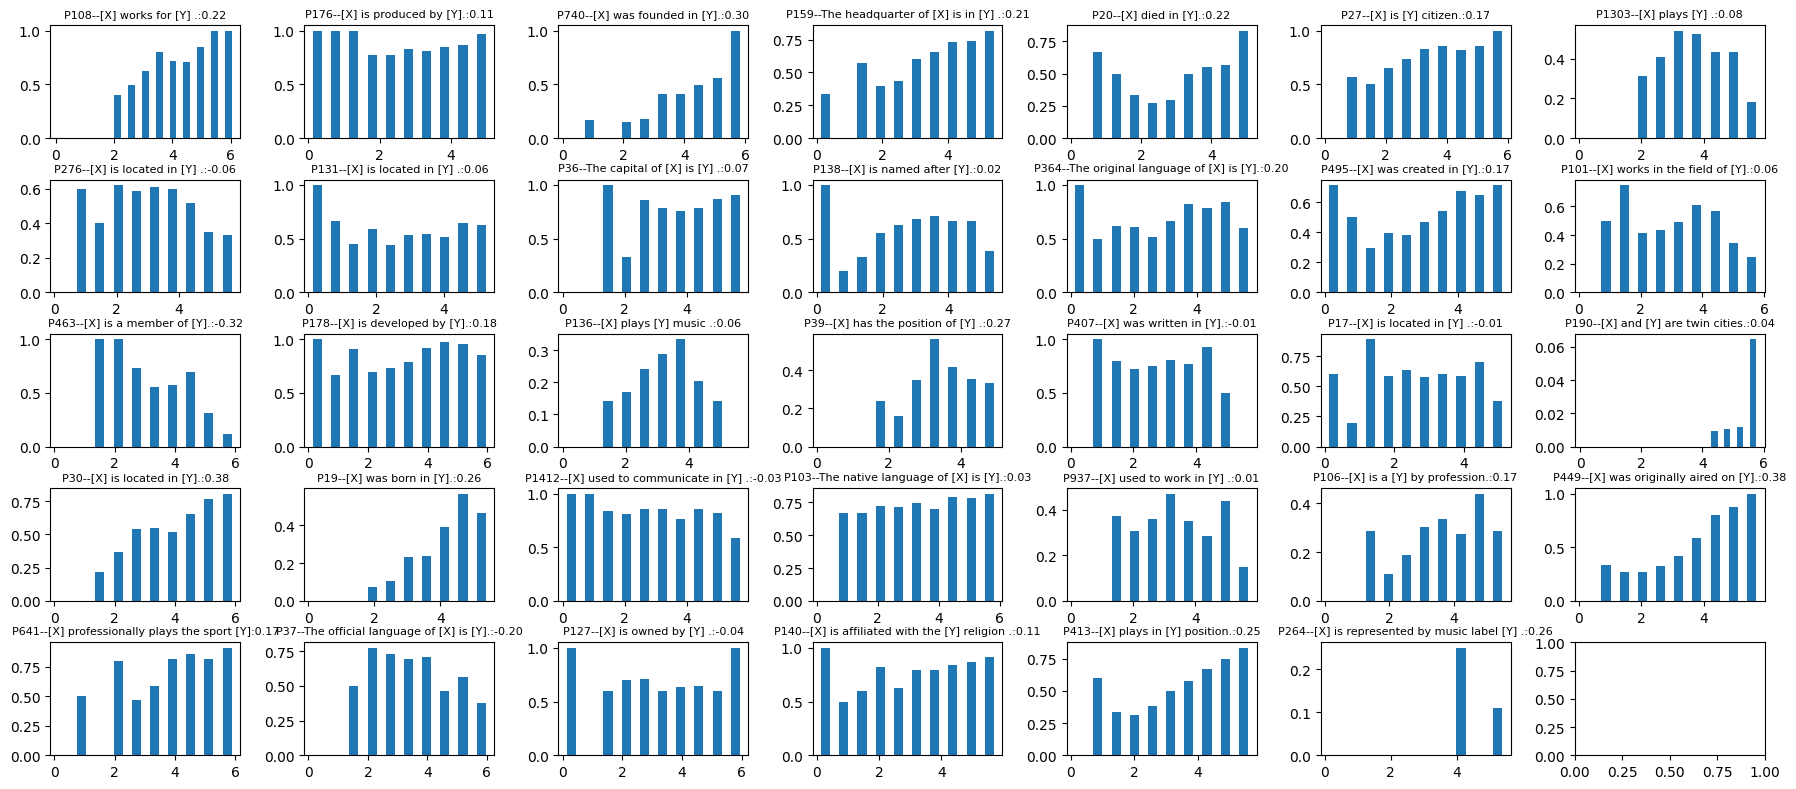

In [23]:
fig, axs = pyplot.subplots(5,7, figsize=(18,8))

# for i,fi in enumerate(figures):
print(len(axs.flat), len(figures))
for i, ax in enumerate(axs.flat):
    if i >=len(figures):
        break
    ax.bar(figures[i][0], figures[i][1], figures[i][2])
    ax.set_title(labels[i],fontsize=8)
fig.tight_layout(h_pad=0.1)
# pyplot.savefig('corr_v2.pdf')
    # fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,\
    #     ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax25,ax26,ax27,ax28,ax29,ax30,ax31,ax32,ax33,ax34)= pyplot.subplots(5, 7)
    # pyplot.bar(fi[0], fi[1], fi[2])
    # pyplot.show()
# pyplot.show()


In [79]:
# for i,fi in enumerate(figures):
#     pyplot.bar(fi[0], fi[1], fi[2])
#     pyplot.subplot(5, 7, i + 1)
#     pyplot.show()
# pyplot.show()


<Figure size 640x480 with 0 Axes>

In [43]:
fi

[[0.3043531515855441,
  0.9130594547566323,
  1.5217657579277204,
  2.130472061098809,
  2.739178364269897,
  3.347884667440985,
  3.956590970612073,
  4.565297273783162,
  5.17400357695425,
  5.782709880125338],
 [0.7272727272727273,
  0.0,
  0.6,
  0.7,
  0.7126436781609196,
  0.5967741935483871,
  0.6326530612244898,
  0.6451612903225806,
  0.6,
  1.0],
 0.3043531515855441]

In [87]:
def perplexity(model,tok,prompt: str,compl: str):
    inputs = tok(
        [prompt + compl], return_tensors="pt").to(device)
    input_token_len = tok(prompt, return_tensors="pt")["input_ids"].size(1)
    # print(prompt, compl, input_token_len, inputs["input_ids"].size(1))
    with torch.no_grad():
        logits = torch.nn.functional.log_softmax(model(**inputs).logits, dim=2)
    log_probs = torch.gather(logits[:, :-1, :], 2, inputs["input_ids"][:, 1:, None])[0]
    log_probs = log_probs[input_token_len-1:]
    # Perplexity = exp(-1/N * log P(x_1, ..., x_n))
    print(inputs["input_ids"][0], len(log_probs))
    return torch.exp(-1 / (inputs["input_ids"].size(1)-input_token_len) * log_probs.sum()).item()
def icl_lm_eval(model, tokenizer, targets, x):
    icl_examples = ''
    ppls = [] 
    for target in targets:
        tgt_len = len(tokenizer.encode(' ' + target))
        print(tgt_len, tokenizer.encode(' ' + target))
        encodings = tokenizer(''.join(icl_examples) + f'{x} {target}', return_tensors='pt')
        input_ids = encodings['input_ids'].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-tgt_len] = -100
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            ppl = torch.exp(outputs.loss)
            ppls.append(ppl.item())
    return ppls

In [88]:
print(perplexity(model, tokenizer, 'The mother tongue of Danielle Darrieux is', ' French'))
print(icl_lm_eval(model, tokenizer, ['French'], 'The mother tongue of Danielle Darrieux is'))
tokenizer.tokenize(' French')

tensor([    1,   450,  5637, 26820,   310,  8432,   280,  7335,  2546,  1314,
          338,  5176], device='cuda:6') 1
1.0010545253753662
3 [1, 29871, 5176]
[1.4633910655975342]


['▁', '▁French']